In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering, OPTICS
from sklearn.metrics import silhouette_score
import hdbscan
import time
import pandas as pd
from scipy.sparse import lil_matrix
import ast

# Load CSV
df = pd.read_csv('../data/afterllm/ingredients_reduced.csv')

# Parse the string ingredients to list
if isinstance(df['ingredients'].iloc[0], str):
    df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Build the vocabulary
all_ingredients = []
for ing_list in df['ingredients']:
    all_ingredients.extend(set(ing_list))  # Use set to avoid duplicates in a single recipe

unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n_ingredients = len(unique_ingredients)
n_recipes = len(df)

print(f"Total recipes: {n_recipes}")
print(f"Total unique ingredients: {n_ingredients}")

# Build the sparse matrix (recipes x ingredients)
X = lil_matrix((n_recipes, n_ingredients), dtype=bool)

for r, ing_list in enumerate(df['ingredients']):
    for ing in set(ing_list):
        if ing in ingredients_index:
            X[r, ingredients_index[ing]] = True

print(f"Sparse matrix shape: {X.shape}")
print(f"Sparsity: {1 - X.nnz / (X.shape[0]*X.shape[1]):.4f}") 

X = X.tocsr()
X_ingredients = X.T

print("\n2. HDBSCAN (DENSITY-BASED)")

# Reduce dimensions first (HDBSCAN works better in lower dimensions)
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

print("Reducing to 100 dimensions for HDBSCAN...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced_hdb = normalize(svd.fit_transform(X_ingredients))

X_reduced_db = normalize(svd.fit_transform(X_ingredients))

start = time.time()

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Minimum ingredients per cluster
    min_samples=5,
    metric='euclidean',
    cluster_selection_epsilon=0.5,
    core_dist_n_jobs=-1
)

labels_hdb = clusterer.fit_predict(X_reduced_hdb)
time_hdb = time.time() - start

n_clusters_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
n_noise = np.sum(labels_hdb == -1)

print(f"\n Time: {time_hdb:.1f}s")
print(f"  Clusters found: {n_clusters_hdb}")
print(f"  Noise points: {n_noise} ({n_noise/len(labels_hdb)*100:.1f}%)")

# Evaluate (excluding noise)
mask = labels_hdb != -1
if np.sum(mask) > 100 and len(set(labels_hdb[mask])) > 1:
    sample_idx = np.random.choice(np.where(mask)[0], min(3000, np.sum(mask)), replace=False)
    sil_hdb = silhouette_score(X_reduced_hdb[sample_idx], labels_hdb[sample_idx])
    print(f"  Silhouette score (no noise): {sil_hdb:.3f}")

# Save
np.save('labels_hdbscan.npy', labels_hdb)

# print("\n3. OPTICS (DENSITY-BASED ALTERNATIVE)")

# # Use same reduced data
# start = time.time()

# optics = OPTICS(
#     min_samples=10,
#     max_eps=2.0,
#     metric='euclidean',
#     cluster_method='xi',
#     n_jobs=-1
# )

# labels_opt = optics.fit_predict(X_reduced_hdb)
# time_opt = time.time() - start

# n_clusters_opt = len(set(labels_opt)) - (1 if -1 in labels_opt else 0)
# n_noise_opt = np.sum(labels_opt == -1)

# print(f"\n✓ Time: {time_opt:.1f}s")
# print(f"  Clusters found: {n_clusters_opt}")
# print(f"  Noise points: {n_noise_opt} ({n_noise_opt/len(labels_opt)*100:.1f}%)")

# # Evaluate
# mask_opt = labels_opt != -1
# if np.sum(mask_opt) > 100 and len(set(labels_opt[mask_opt])) > 1:
#     sample_idx = np.random.choice(np.where(mask_opt)[0], min(3000, np.sum(mask_opt)), replace=False)
#     sil_opt = silhouette_score(X_reduced_hdb[sample_idx], labels_opt[sample_idx])
#     print(f"  Silhouette score (no noise): {sil_opt:.3f}")

# # Save
# np.save('labels_optics.npy', labels_opt)

print("\n5. DBSCAN (BASELINE)")

from sklearn.cluster import DBSCAN

start = time.time()

dbscan = DBSCAN(
    eps=0.65,          # distance threshold — adjust later via tuning
    min_samples=10,   # similar to HDBSCAN min_cluster_size
    metric='euclidean',
    n_jobs=-1
)

labels_db = dbscan.fit_predict(X_reduced_db)
time_db = time.time() - start

n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_db = np.sum(labels_db == -1)

print(f"\n Time: {time_db:.1f}s")
print(f"  Clusters found: {n_clusters_db}")
print(f"  Noise points: {n_noise_db} ({n_noise_db/len(labels_db)*100:.1f}%)")

# Evaluate
mask_db = labels_db != -1
if np.sum(mask_db) > 100 and len(set(labels_db[mask_db])) > 1:
    sample_idx = np.random.choice(np.where(mask_db)[0], min(3000, np.sum(mask_db)), replace=False)
    sil_db = silhouette_score(X_reduced_hdb[sample_idx], labels_db[sample_idx])
    print(f"  Silhouette score (no noise): {sil_db:.3f}")

# Save
np.save('labels_dbscan.npy', labels_db)



print(f"\n{'Method':<25} {'Clusters':<12} {'Silhouette':<12} {'Time (s)'}")
print(f"{'K-Means (Full)':<25} {148:<12} {-0.503:<12.3f} {10.6:.1f}")
print(f"{'HDBSCAN':<25} {n_clusters_hdb:<12} {sil_hdb if 'sil_hdb' in locals() else 'N/A':<12} {time_hdb:.1f}")
# print(f"{'OPTICS':<25} {n_clusters_opt:<12} {sil_opt if 'sil_opt' in locals() else 'N/A':<12} {time_opt:.1f}")
print(f"{'DBSCAN':<25} {n_clusters_db:<12} {sil_db if 'sil_db' in locals() else 'N/A':<12} {time_db:.1f}")

Total recipes: 222705
Total unique ingredients: 9864
Sparse matrix shape: (222705, 9864)
Sparsity: 0.9991

2. HDBSCAN (DENSITY-BASED)
Reducing to 100 dimensions for HDBSCAN...


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 Time: 7.2s
  Clusters found: 41
  Noise points: 8797 (89.2%)
  Silhouette score (no noise): 0.333

5. DBSCAN (BASELINE)
--------------------------------------------------------------------------------

✓ Time: 0.3s
  Clusters found: 30
  Noise points: 8179 (82.9%)
  Silhouette score (no noise): 0.139

Method                    Clusters     Silhouette   Time (s)
K-Means (Full)            148          -0.503       10.6
HDBSCAN                   41           0.3334017899427836 7.2
DBSCAN                    30           0.13925215264368893 0.3


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== INTERPRETING CLUSTERS (HDBSCAN) ===
Non-noise clusters: 41
Cluster size range: 10 – 184

Sample of top ingredients per cluster:
  Cluster   0: boneless duck leg, bonito tuna, chicken broth soup, dove breasts, fat free hollandaise mix, fat free vegetable soup, honeybalsamic vinaigrette, lean pork steak, lowfat pepperoni, mushroom
  Cluster   1: avgolemono sauce, chestnut meats, corned beef spread, egglandes best eggs, hamour fish, italian sweet vermouth, lawrys southwest marinade, pepper, velveeta american cheese spread, vidalia onion spreadable cheese
  Cluster   2: blended scotch whisky, chunky turkey pot pie soup, dried kelp granules, el torito adobo al pastor sauce, granary bread, lamb baby food, lightlife turkey slices, lowcarb linguine, morningstar farms original chik patty, muskellunge
  Cluster   3: crookneck yellow squash, fruit jell, indian spicy mango pickle, korma sauce, pesto garlic tortillas, philadelphia italian cheese and herb cooking creme, roasted red pepper pesto

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


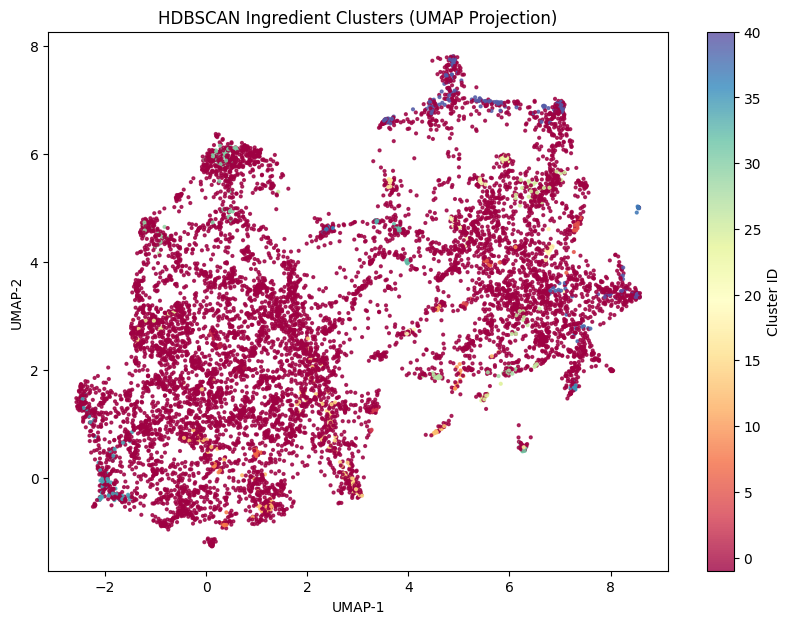

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from umap import UMAP

labels = labels_hdb
cluster_method_name = "HDBSCAN"

ingredient_names = unique_ingredients
X_reduced = X_reduced_hdb  # 100D reduced data used in HDBSCAN & OPTICS & DBSCAN
print(f"\n=== INTERPRETING CLUSTERS ({cluster_method_name}) ===")

ingredient_clusters = pd.DataFrame({
    "ingredient": ingredient_names,
    "cluster": labels
})

valid_clusters = ingredient_clusters[ingredient_clusters.cluster != -1]
cluster_sizes = valid_clusters["cluster"].value_counts().sort_index()
print(f"Non-noise clusters: {len(cluster_sizes)}")
print(f"Cluster size range: {cluster_sizes.min()} – {cluster_sizes.max()}")

def top_ingredients_per_cluster(df, n=10):
    cluster_summary = {}
    for c, sub in df.groupby("cluster"):
        cluster_summary[c] = sub["ingredient"].value_counts().head(n).index.tolist()
    return cluster_summary

cluster_summary = top_ingredients_per_cluster(valid_clusters, n=10)

print("\nSample of top ingredients per cluster:")
for cid, ingredients in list(cluster_summary.items())[:5]:
    print(f"  Cluster {cid:>3}: {', '.join(ingredients)}")

# Visualization using UMAP

umap_model = UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
embedding = umap_model.fit_transform(X_reduced)

plt.figure(figsize=(10, 7))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels,
    s=4,
    cmap="Spectral",
    alpha=0.8
)
plt.colorbar(label="Cluster ID")
plt.title(f"{cluster_method_name} Ingredient Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


ingredient_clusters.to_csv("ingredient_clusters_hdbscan.csv", index=False)
summary_df = pd.DataFrame([
    {"cluster": cid, "top_ingredients": ", ".join(ings)}
    for cid, ings in cluster_summary.items()
])
summary_df.to_csv("cluster_summary_hdbscan.csv", index=False)



=== INTERPRETING CLUSTERS (DBSCAN) ===
Non-noise clusters: 30
Cluster size range: 9 – 820

Sample of top ingredients per cluster:
  Cluster   0: absinthe, peach liqueur, orgeat syrup, pace picante sauce, papaya, papaya nectar, passion fruit, passion fruit and strawberry salad dressing, passion fruit liqueur, passion fruit nectar
  Cluster   1: ahmed brand vermicelli, kremelta, vita brits, smart start cereal, sapodilla, royal ann cherries, raisins, pretzel rings, nestle sugarfree turtles, gummy bears
  Cluster   2: ajwain, peanut sauce, pickled ginger, plum sauce, poppy seed paste, prawns, preserved black bean, prik chi fa daeng, ramen noodles, raw jasmine rice
  Cluster   3: albacore tuna, betty crocker suddenly pasta salad classic, olivepimento cheese spread, pickle, pickle juice, pickle relish, pimentos, pimiento cheese spread, relish, roll
  Cluster   4: alfredo noodles mix, fatfree balsamic vinegar, frozen mozzarella garlic bread, hidden valley original ranch cheddar and parmesan 

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


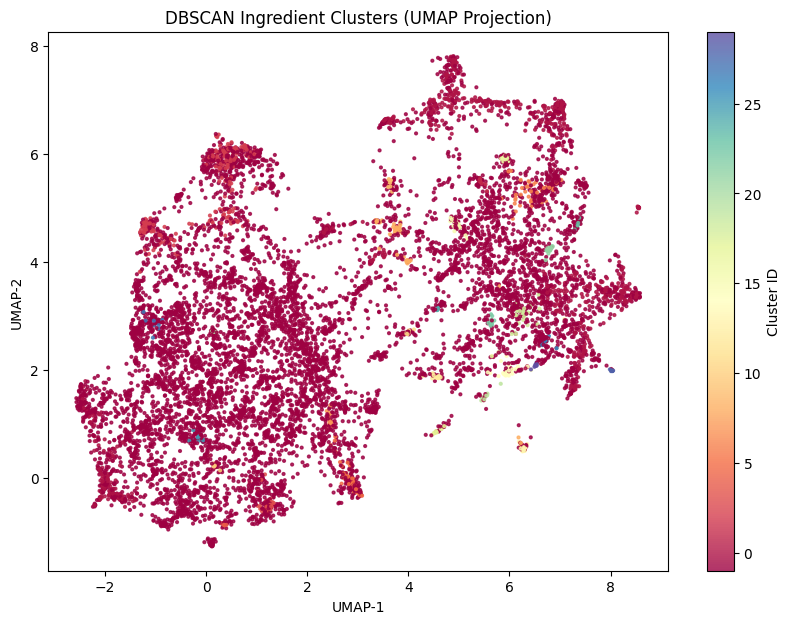

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from umap import UMAP

labels = labels_db
cluster_method_name = "DBSCAN"

ingredient_names = unique_ingredients
X_reduced = X_reduced_hdb  # 100D reduced data used in HDBSCAN & OPTICS & DBSCAN
print(f"\n=== INTERPRETING CLUSTERS ({cluster_method_name}) ===")

ingredient_clusters = pd.DataFrame({
    "ingredient": ingredient_names,
    "cluster": labels
})

valid_clusters = ingredient_clusters[ingredient_clusters.cluster != -1]
cluster_sizes = valid_clusters["cluster"].value_counts().sort_index()
print(f"Non-noise clusters: {len(cluster_sizes)}")
print(f"Cluster size range: {cluster_sizes.min()} – {cluster_sizes.max()}")

def top_ingredients_per_cluster(df, n=10):
    cluster_summary = {}
    for c, sub in df.groupby("cluster"):
        cluster_summary[c] = sub["ingredient"].value_counts().head(n).index.tolist()
    return cluster_summary

cluster_summary = top_ingredients_per_cluster(valid_clusters, n=10)

print("\nSample of top ingredients per cluster:")
for cid, ingredients in list(cluster_summary.items())[:5]:
    print(f"  Cluster {cid:>3}: {', '.join(ingredients)}")

# Visualization using UMAP

umap_model = UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
embedding = umap_model.fit_transform(X_reduced)

plt.figure(figsize=(10, 7))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels,
    s=4,
    cmap="Spectral",
    alpha=0.8
)
plt.colorbar(label="Cluster ID")
plt.title(f"{cluster_method_name} Ingredient Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


ingredient_clusters.to_csv("ingredient_clusters_dbscan.csv", index=False)
summary_df = pd.DataFrame([
    {"cluster": cid, "top_ingredients": ", ".join(ings)}
    for cid, ings in cluster_summary.items()
])
summary_df.to_csv("cluster_summary_dbscan.csv", index=False)



=== UMAP VISUALIZATION OF HDBSCAN CLUSTERS ===


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


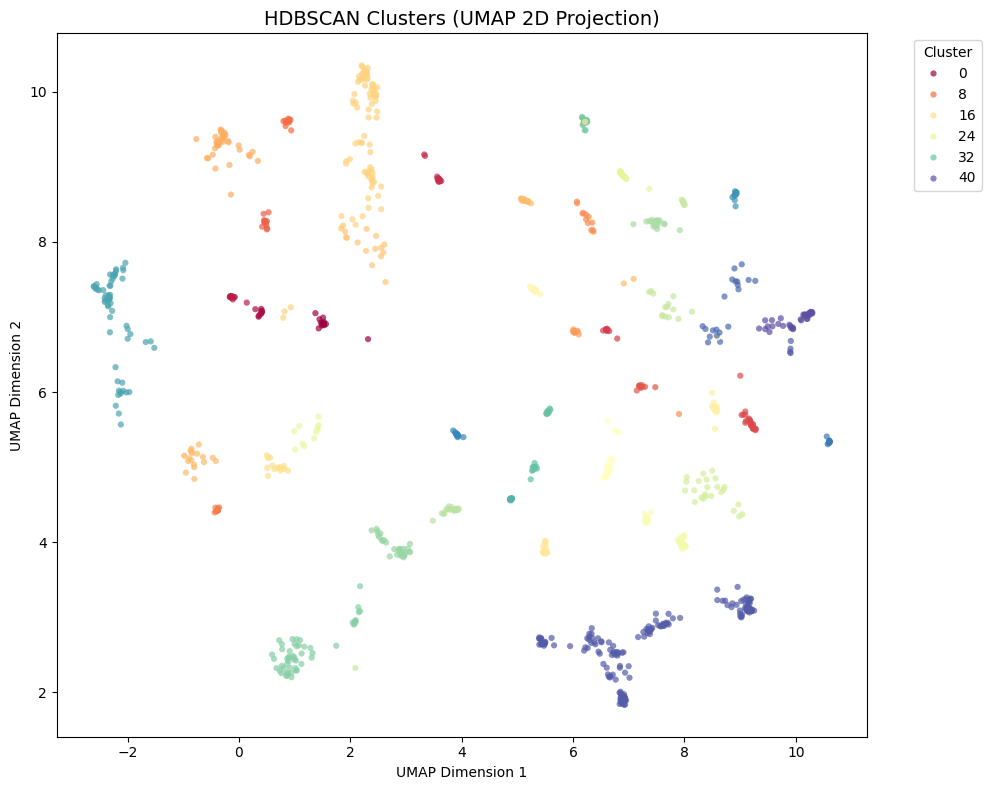

In [4]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd


print("\n=== UMAP VISUALIZATION OF HDBSCAN CLUSTERS ===")

# Reduce to 2D with UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
embedding = umap_model.fit_transform(X_reduced_hdb)

# Convert to DataFrame
df_umap = pd.DataFrame({
    'x': embedding[:, 0],
    'y': embedding[:, 1],
    'cluster': labels_hdb
})

# Filter out noise for clarity
df_clusters = df_umap[df_umap['cluster'] != -1]

plt.figure(figsize=(10, 8))
palette = sns.color_palette('Spectral', as_cmap=True)
sns.scatterplot(
    data=df_clusters,
    x='x', y='y',
    hue='cluster',
    palette='Spectral',
    s=20, linewidth=0, alpha=0.7
)
plt.title("HDBSCAN Clusters (UMAP 2D Projection)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Interactive Plotly scatter
fig = px.scatter(
    df_clusters,
    x='x', y='y',
    color='cluster',
    color_continuous_scale='Spectral',
    hover_data={'x': False, 'y': False, 'cluster': True},
    title="Interactive UMAP Visualization of HDBSCAN Clusters"
)
fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(
    width=900, height=700,
    template='plotly_white',
    showlegend=True
)
fig.show()



=== UMAP VISUALIZATION OF DBSCAN CLUSTERS ===


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



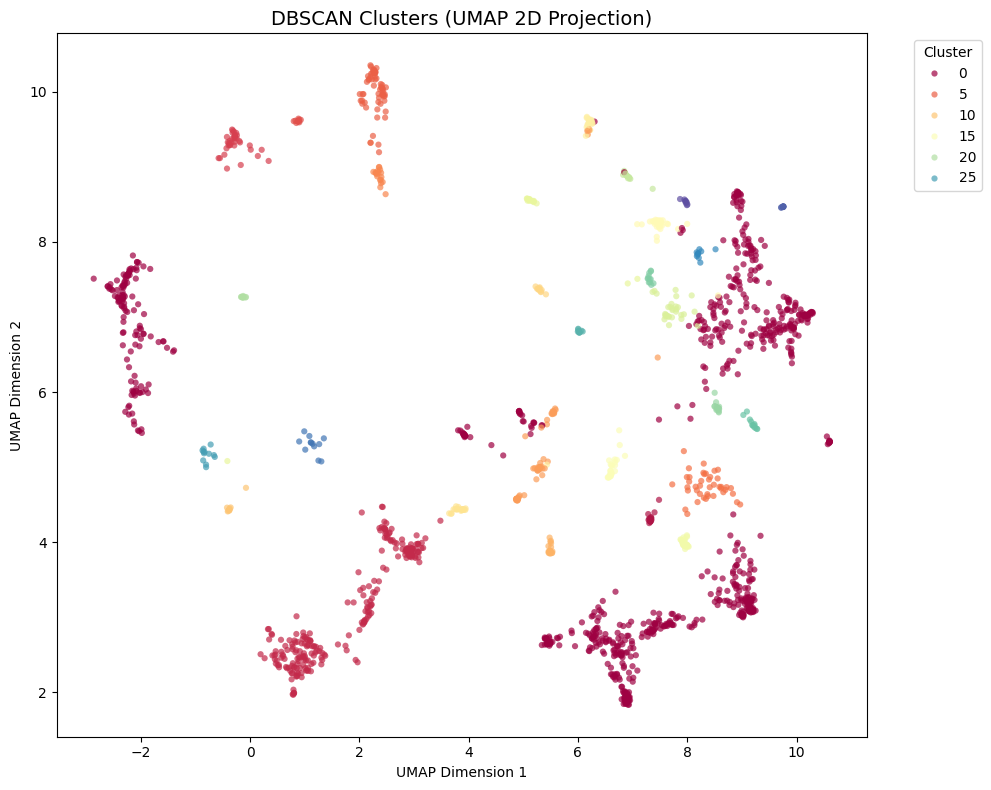

In [5]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd


print("\n=== UMAP VISUALIZATION OF DBSCAN CLUSTERS ===")

# Reduce to 2D with UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
embedding = umap_model.fit_transform(X_reduced_db)

# Convert to DataFrame
df_umap = pd.DataFrame({
    'x': embedding[:, 0],
    'y': embedding[:, 1],
    'cluster': labels_db
})

# Filter out noise for clarity
df_clusters = df_umap[df_umap['cluster'] != -1]

plt.figure(figsize=(10, 8))
palette = sns.color_palette('Spectral', as_cmap=True)
sns.scatterplot(
    data=df_clusters,
    x='x', y='y',
    hue='cluster',
    palette='Spectral',
    s=20, linewidth=0, alpha=0.7
)
plt.title("DBSCAN Clusters (UMAP 2D Projection)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Interactive Plotly scatter
fig = px.scatter(
    df_clusters,
    x='x', y='y',
    color='cluster',
    color_continuous_scale='Spectral',
    hover_data={'x': False, 'y': False, 'cluster': True},
    title="Interactive UMAP Visualization of HDBSCAN Clusters"
)
fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(
    width=900, height=700,
    template='plotly_white',
    showlegend=True
)
fig.show()



=== HIERARCHICAL CLUSTERING ===

Testing ward linkage with 10 clusters
  Silhouette: 0.010, CH: 119.6, DB: 4.445

Testing ward linkage with 20 clusters
  Silhouette: 0.016, CH: 90.5, DB: 4.235

Testing ward linkage with 30 clusters
  Silhouette: 0.016, CH: 76.8, DB: 3.864

Testing ward linkage with 40 clusters
  Silhouette: 0.018, CH: 68.0, DB: 3.646

Testing ward linkage with 50 clusters
  Silhouette: 0.022, CH: 61.6, DB: 3.472

Testing complete linkage with 10 clusters
  Silhouette: -0.003, CH: 37.5, DB: 8.682

Testing complete linkage with 20 clusters
  Silhouette: -0.003, CH: 33.6, DB: 6.815

Testing complete linkage with 30 clusters
  Silhouette: -0.002, CH: 32.3, DB: 5.664

Testing complete linkage with 40 clusters
  Silhouette: 0.000, CH: 33.3, DB: 4.993

Testing complete linkage with 50 clusters
  Silhouette: -0.001, CH: 32.4, DB: 4.647

Testing average linkage with 10 clusters
  Silhouette: 0.002, CH: 49.9, DB: 4.139

Testing average linkage with 20 clusters
  Silhouette: -0.

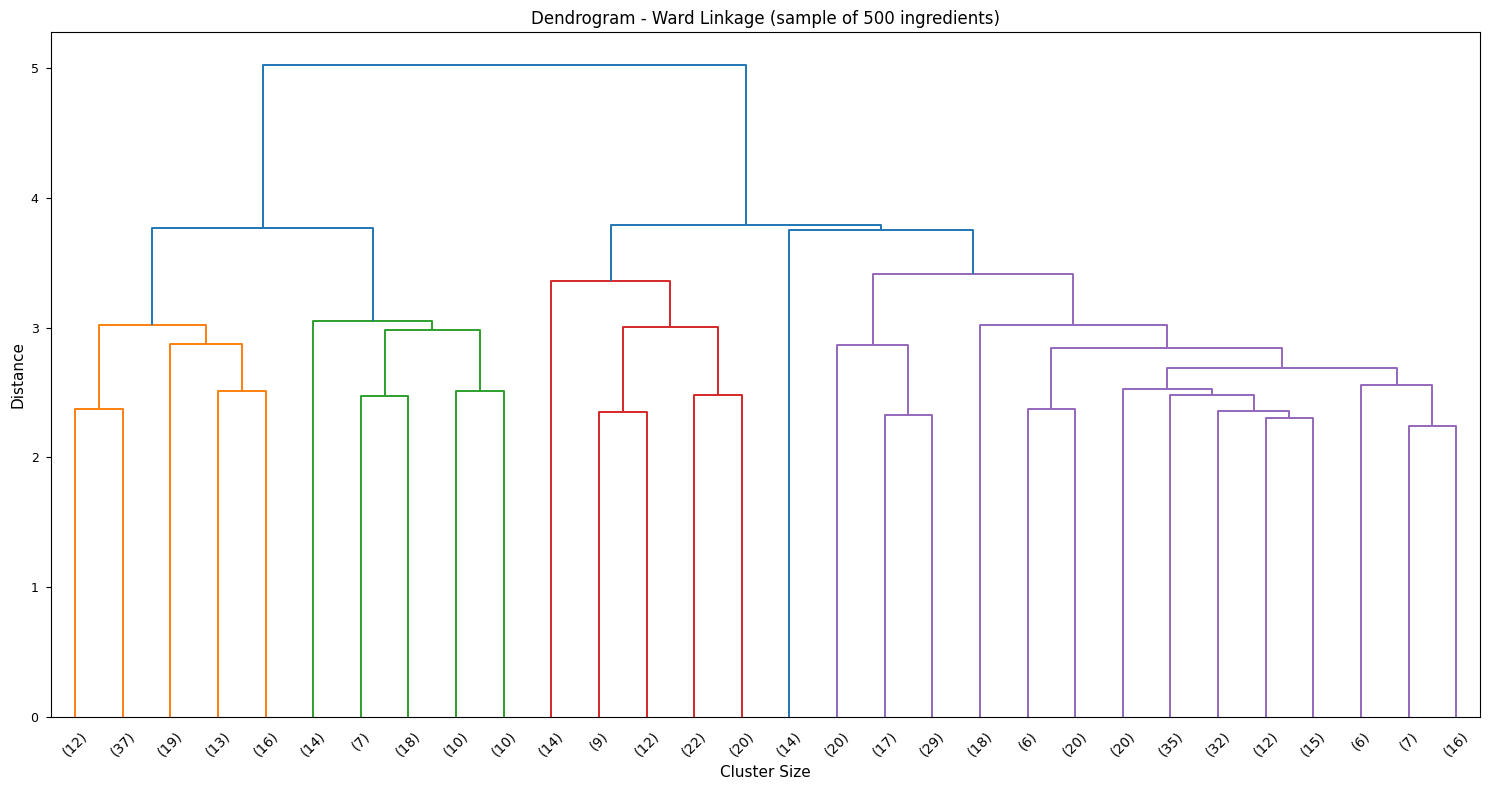

In [19]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

print("\n=== HIERARCHICAL CLUSTERING ===")

# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters_range = [10, 20, 30, 40, 50]

hierarchical_results = []

for linkage_method in linkage_methods:
    for n_clusters in n_clusters_range:
        print(f"\nTesting {linkage_method} linkage with {n_clusters} clusters")
        
        start = time.time()
        
        # Use reduced data (100D) for computational efficiency
        agg = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_method,
            metric='euclidean'
        )
        
        labels_agg = agg.fit_predict(X_reduced_hdb)
        elapsed = time.time() - start
        
        # Evaluate
        sil = silhouette_score(X_reduced_hdb, labels_agg, sample_size=n_ingredients)
        ch = calinski_harabasz_score(X_reduced_hdb, labels_agg)
        db = davies_bouldin_score(X_reduced_hdb, labels_agg)
        
        hierarchical_results.append({
            'linkage': linkage_method,
            'n_clusters': n_clusters,
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': db,
            'time': elapsed
        })
        
        print(f"  Silhouette: {sil:.3f}, CH: {ch:.1f}, DB: {db:.3f}")

hierarchical_df = pd.DataFrame(hierarchical_results)
hierarchical_df.to_csv('hierarchical_clustering_results.csv', index=False)

# Find optimal configuration
best_hier = hierarchical_df.loc[hierarchical_df['silhouette'].idxmax()]
print(f"\n Best hierarchical: {best_hier['linkage']} with {best_hier['n_clusters']} clusters")
print(f"  Silhouette: {best_hier['silhouette']:.3f}")

# Create dendrogram for best linkage (on sample for visualization)
sample_size = n_ingredients
sample_idx = np.random.choice(X_reduced_hdb.shape[0], sample_size, replace=False)
X_sample = X_reduced_hdb[sample_idx]

plt.figure(figsize=(15, 8))
Z = linkage(X_sample, method=best_hier['linkage'])
dendrogram(Z, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.title(f"Dendrogram - {best_hier['linkage'].capitalize()} Linkage (sample of {sample_size} ingredients)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
# plt.savefig('dendrogram_hierarchical.png', dpi=300)
plt.show()


=== BEST HIERARCHICAL CONFIGURATION ===
linkage                   ward
n_clusters                  50
silhouette            0.022083
calinski_harabasz    61.579509
davies_bouldin        3.471677
time                   2.17721
Name: 4, dtype: object

Re-running clustering with linkage='ward', n_clusters=50

=== CLUSTER SIZE SUMMARY ===
Cluster 0: 261 samples
Cluster 1: 283 samples
Cluster 2: 124 samples
Cluster 3: 260 samples
Cluster 4: 389 samples
Cluster 5: 1343 samples
Cluster 6: 273 samples
Cluster 7: 319 samples
Cluster 8: 203 samples
Cluster 9: 192 samples
Cluster 10: 163 samples
Cluster 11: 306 samples
Cluster 12: 281 samples
Cluster 13: 162 samples
Cluster 14: 201 samples
Cluster 15: 309 samples
Cluster 16: 243 samples
Cluster 17: 211 samples
Cluster 18: 184 samples
Cluster 19: 250 samples
Cluster 20: 339 samples
Cluster 21: 82 samples
Cluster 22: 132 samples
Cluster 23: 390 samples
Cluster 24: 208 samples
Cluster 25: 270 samples
Cluster 26: 117 samples
Cluster 27: 124 samples


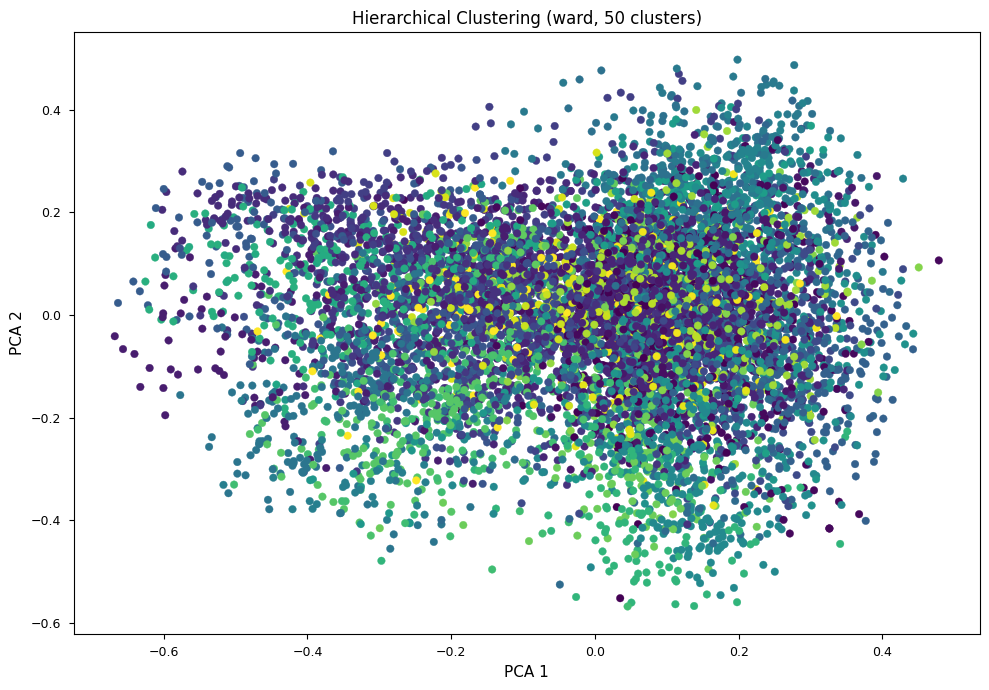

In [23]:
# === Inspect and visualize the best hierarchical clustering ===

# 1. Show details of best_hier
print("\n=== BEST HIERARCHICAL CONFIGURATION ===")
print(best_hier)

best_linkage = best_hier['linkage']
best_n_clusters = int(best_hier['n_clusters'])
print(f"\nRe-running clustering with linkage='{best_linkage}', n_clusters={best_n_clusters}")

# 2. Fit clustering again with best parameters
agg_best = AgglomerativeClustering(
    n_clusters=best_n_clusters,
    linkage=best_linkage,
    metric='euclidean'
)
best_labels = agg_best.fit_predict(X_reduced_hdb)

# 3. Explore cluster composition
print("\n=== CLUSTER SIZE SUMMARY ===")
unique, counts = np.unique(best_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# 4. Visualize clusters in 2D using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_reduced_hdb)

plt.figure(figsize=(10, 7))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=best_labels, s=30)
plt.title(f"Hierarchical Clustering ({best_linkage}, {best_n_clusters} clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

# # 5. (Optional) Save cluster assignments
# df_clusters = pd.DataFrame({
#     'sample_index': np.arange(len(best_labels)),
#     'cluster': best_labels
# })
# df_clusters.to_csv('best_hier_clusters.csv', index=False)
# print("\nCluster assignments saved to 'best_hier_clusters.csv'")



COMPREHENSIVE CLUSTERING COMPARISON

1. K-Means (Partitioning baseline)

2. DBSCAN (Density-based)

3. HDBSCAN (Hierarchical density-based)


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/duybeobn1/min


4. Agglomerative Clustering (Hierarchical)

RESULTS SUMMARY
       Method      Variant  N_Clusters  Silhouette  Davies_Bouldin  Time_seconds
       DBSCAN      eps=0.5          18    0.424483        0.940793      0.216034
      HDBSCAN       mcs=15          25    0.340551        1.200961      7.169742
      HDBSCAN       mcs=10          41    0.333402        1.161302      6.996204
       DBSCAN      eps=0.6          26    0.231378        1.266548      0.184681
       DBSCAN     eps=0.65          30    0.139252        1.488267      0.193125
      K-Means        k=100         100    0.058774        2.751938      0.078467
      K-Means         k=50          50    0.056913        3.225309      0.050174
      K-Means         k=40          40    0.056374        3.428685      0.053677
      K-Means         k=30          30    0.055464        3.597533      0.040822
      K-Means         k=20          20    0.048801        3.991574      0.051007
      HDBSCAN       mcs=20           2    0.0191

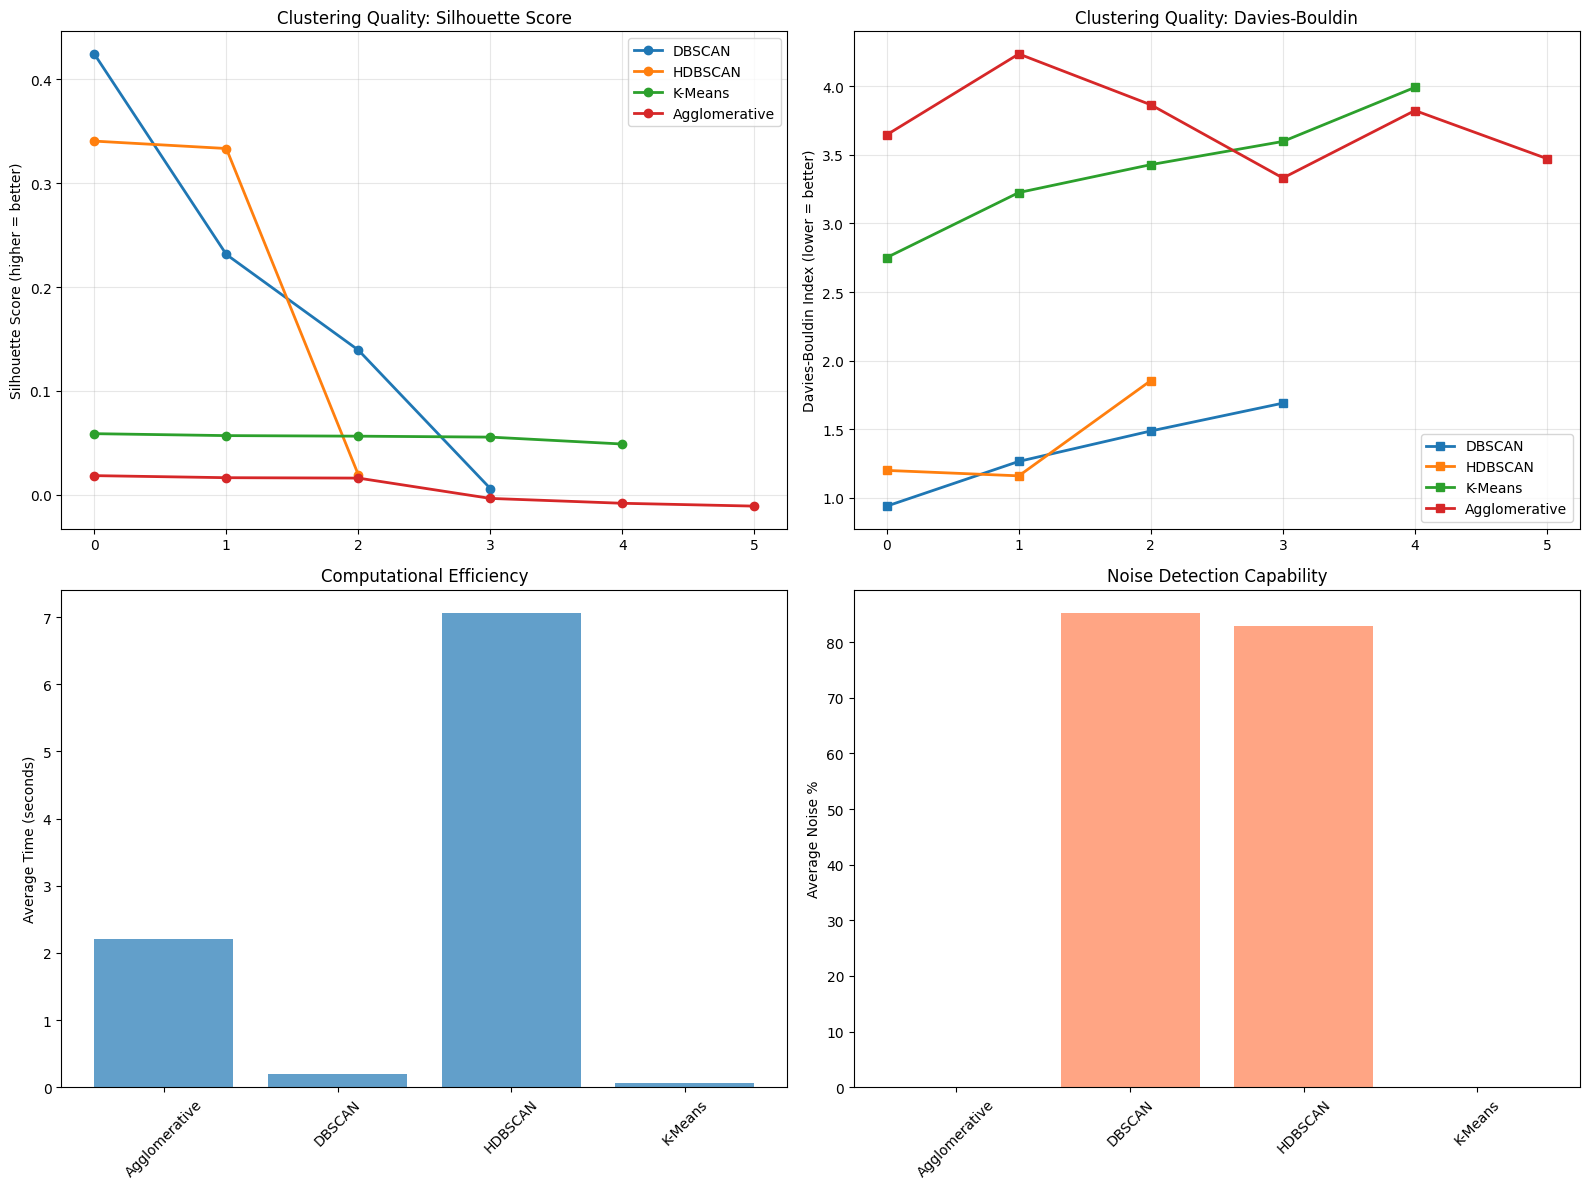

In [8]:
def comprehensive_clustering_comparison():
    """
    Compare ALL clustering methods systematically
    """
    
    
    methods_to_compare = []
    
    # 1. K-Means (baseline)
    print("\n1. K-Means (Partitioning baseline)")
    from sklearn.cluster import KMeans, MiniBatchKMeans
    
    for k in [20, 30, 40, 50, 100]:
        start = time.time()
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
        labels_km = kmeans.fit_predict(X_reduced_hdb)
        elapsed = time.time() - start
        
        sil = silhouette_score(X_reduced_hdb, labels_km, sample_size=5000)
        ch = calinski_harabasz_score(X_reduced_hdb, labels_km)
        db = davies_bouldin_score(X_reduced_hdb, labels_km)
        
        methods_to_compare.append({
            'Method': 'K-Means',
            'Variant': f'k={k}',
            'N_Clusters': k,
            'Noise_Points': 0,
            'Noise_Pct': 0.0,
            'Silhouette': sil,
            'Calinski_Harabasz': ch,
            'Davies_Bouldin': db,
            'Time_seconds': elapsed,
            'Can_Find_Arbitrary_Shapes': False,
            'Requires_K': True,
            'Handles_Noise': False,
            'Hierarchical': False
        })
    
    # 2. DBSCAN (current best)
    print("\n2. DBSCAN (Density-based)")
    for eps in [0.5, 0.6, 0.65, 0.7]:
        start = time.time()
        dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', n_jobs=-1)
        labels_db = dbscan.fit_predict(X_reduced_hdb)
        elapsed = time.time() - start
        
        mask = labels_db != -1
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        noise_pct = (len(labels_db) - np.sum(mask)) / len(labels_db) * 100
        
        if np.sum(mask) > 100 and n_clusters > 1:
            sil = silhouette_score(X_reduced_hdb[mask], labels_db[mask], sample_size=3000)
            ch = calinski_harabasz_score(X_reduced_hdb[mask], labels_db[mask])
            db_score = davies_bouldin_score(X_reduced_hdb[mask], labels_db[mask])
        else:
            sil, ch, db_score = None, None, None
        
        methods_to_compare.append({
            'Method': 'DBSCAN',
            'Variant': f'eps={eps}',
            'N_Clusters': n_clusters,
            'Noise_Points': len(labels_db) - np.sum(mask),
            'Noise_Pct': noise_pct,
            'Silhouette': sil,
            'Calinski_Harabasz': ch,
            'Davies_Bouldin': db_score,
            'Time_seconds': elapsed,
            'Can_Find_Arbitrary_Shapes': True,
            'Requires_K': False,
            'Handles_Noise': True,
            'Hierarchical': False
        })
    
    # 3. HDBSCAN (current best)
    print("\n3. HDBSCAN (Hierarchical density-based)")
    for mcs in [10, 15, 20]:
        start = time.time()
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=5,
            metric='euclidean',
            cluster_selection_epsilon=0.5
        )
        labels_hdb = clusterer.fit_predict(X_reduced_hdb)
        elapsed = time.time() - start
        
        mask = labels_hdb != -1
        n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
        noise_pct = (len(labels_hdb) - np.sum(mask)) / len(labels_hdb) * 100
        
        if np.sum(mask) > 100 and n_clusters > 1:
            sil = silhouette_score(X_reduced_hdb[mask], labels_hdb[mask], sample_size=3000)
            ch = calinski_harabasz_score(X_reduced_hdb[mask], labels_hdb[mask])
            db_score = davies_bouldin_score(X_reduced_hdb[mask], labels_hdb[mask])
        else:
            sil, ch, db_score = None, None, None
        
        methods_to_compare.append({
            'Method': 'HDBSCAN',
            'Variant': f'mcs={mcs}',
            'N_Clusters': n_clusters,
            'Noise_Points': len(labels_hdb) - np.sum(mask),
            'Noise_Pct': noise_pct,
            'Silhouette': sil,
            'Calinski_Harabasz': ch,
            'Davies_Bouldin': db_score,
            'Time_seconds': elapsed,
            'Can_Find_Arbitrary_Shapes': True,
            'Requires_K': False,
            'Handles_Noise': True,
            'Hierarchical': True
        })
    
    # 4. Hierarchical (from previous section)
    print("\n4. Agglomerative Clustering (Hierarchical)")
    for linkage in ['ward', 'average']:
        for k in [20, 30, 40]:
            start = time.time()
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels_agg = agg.fit_predict(X_reduced_hdb)
            elapsed = time.time() - start
            
            sil = silhouette_score(X_reduced_hdb, labels_agg, sample_size=n_ingredients)
            ch = calinski_harabasz_score(X_reduced_hdb, labels_agg)
            db_score = davies_bouldin_score(X_reduced_hdb, labels_agg)
            
            methods_to_compare.append({
                'Method': 'Agglomerative',
                'Variant': f'{linkage}-k={k}',
                'N_Clusters': k,
                'Noise_Points': 0,
                'Noise_Pct': 0.0,
                'Silhouette': sil,
                'Calinski_Harabasz': ch,
                'Davies_Bouldin': db_score,
                'Time_seconds': elapsed,
                'Can_Find_Arbitrary_Shapes': False,
                'Requires_K': True,
                'Handles_Noise': False,
                'Hierarchical': True
            })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(methods_to_compare)
    comparison_df = comparison_df.sort_values('Silhouette', ascending=False)
    
    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    print(comparison_df[['Method', 'Variant', 'N_Clusters', 'Silhouette', 
                         'Davies_Bouldin', 'Time_seconds']].to_string(index=False))
    
    # comparison_df.to_csv('comprehensive_method_comparison.csv', index=False)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Silhouette comparison
    for method in comparison_df['Method'].unique():
        subset = comparison_df[comparison_df['Method'] == method]
        axes[0, 0].plot(range(len(subset)), subset['Silhouette'], 
                       marker='o', label=method, linewidth=2)
    axes[0, 0].set_ylabel('Silhouette Score (higher = better)')
    axes[0, 0].set_title('Clustering Quality: Silhouette Score')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Davies-Bouldin comparison (lower is better)
    for method in comparison_df['Method'].unique():
        subset = comparison_df[comparison_df['Method'] == method]
        axes[0, 1].plot(range(len(subset)), subset['Davies_Bouldin'], 
                       marker='s', label=method, linewidth=2)
    axes[0, 1].set_ylabel('Davies-Bouldin Index (lower = better)')
    axes[0, 1].set_title('Clustering Quality: Davies-Bouldin')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Computational time
    method_times = comparison_df.groupby('Method')['Time_seconds'].mean()
    axes[1, 0].bar(method_times.index, method_times.values, alpha=0.7)
    axes[1, 0].set_ylabel('Average Time (seconds)')
    axes[1, 0].set_title('Computational Efficiency')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Noise handling
    noise_data = comparison_df.groupby('Method')['Noise_Pct'].mean()
    axes[1, 1].bar(noise_data.index, noise_data.values, alpha=0.7, color='coral')
    axes[1, 1].set_ylabel('Average Noise %')
    axes[1, 1].set_title('Noise Detection Capability')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    # plt.savefig('comprehensive_method_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df

# Run comprehensive comparison
comparison_df = comprehensive_clustering_comparison()

In [12]:

def deep_cluster_interpretation(labels, ingredient_names, df_recipes):
    """
    Go beyond TF-IDF - analyze semantic coherence
    """
    all_ingredients = []
    for ing_list in df['ingredients']:
        all_ingredients.extend(ing_list)
    
    ingredient_freq = pd.Series(all_ingredients).value_counts()
    
    ing_to_cluster = {ing: label for ing, label in zip(ingredient_names, labels)}
    
    cluster_analysis = []
    
    for cluster_id in sorted(set(labels)):
        if cluster_id == -1:
            continue
        
        cluster_ings = [ing for ing, label in zip(ingredient_names, labels) 
                       if label == cluster_id]
        
        if len(cluster_ings) < 3:
            continue
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id}: {len(cluster_ings)} ingredients")
        print(f"{'='*60}")
        
        # 1. Top ingredients by frequency
        ing_freqs = {ing: ingredient_freq.get(ing, 0) for ing in cluster_ings}
        sorted_ings = sorted(ing_freqs.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nTop 10 most frequent:")
        for ing, freq in sorted_ings[:10]:
            print(f"  {ing:<40} {freq:>8,}")
        
        # 2. Co-occurrence within cluster
        cluster_recipes = []
        for _, recipe in df_recipes.iterrows():
            recipe_ings = set(recipe['ingredients'])
            cluster_ings_in_recipe = [ing for ing in cluster_ings if ing in recipe_ings]
            if len(cluster_ings_in_recipe) >= 2:
                cluster_recipes.append(cluster_ings_in_recipe)
        
        avg_co_occurrence = np.mean([len(r) for r in cluster_recipes]) if cluster_recipes else 0
        
        print(f"\nCo-occurrence analysis:")
        print(f"  Recipes containing ≥2 cluster ingredients: {len(cluster_recipes)}")
        print(f"  Avg cluster ingredients per recipe: {avg_co_occurrence:.2f}")
        
        # 3. Semantic coherence score
        # Higher score = ingredients appear together more often
        coherence_score = len(cluster_recipes) / len(cluster_ings) if len(cluster_ings) > 0 else 0
        
        print(f"  Coherence score: {coherence_score:.2f}")
        
        if coherence_score > 10:
            interpretation = "HIGHLY COHERENT - ingredients frequently used together"
        elif coherence_score > 3:
            interpretation = "MODERATELY COHERENT - some culinary relationship"
        else:
            interpretation = "WEAK COHERENCE - may be algorithmic artifact"
        
        print(f"  Interpretation: {interpretation}")
        
        # 4. Suggested category (manual but insightful)
        # Detect patterns in names
        categories = {
            'baking': ['flour', 'sugar', 'baking', 'cake', 'yeast', 'dough'],
            'dairy': ['milk', 'cheese', 'cream', 'butter', 'yogurt'],
            'asian': ['soy', 'sesame', 'ginger', 'rice', 'noodle'],
            'mexican': ['tortilla', 'salsa', 'cilantro', 'jalapeno', 'beans'],
            'spices': ['cumin', 'coriander', 'turmeric', 'paprika', 'chili'],
            'meat': ['chicken', 'beef', 'pork', 'bacon', 'sausage'],
            'seafood': ['fish', 'shrimp', 'tuna', 'salmon', 'crab'],
            'beverages': ['juice', 'coffee', 'tea', 'soda', 'wine'],
            'dessert': ['chocolate', 'vanilla', 'caramel', 'ice cream', 'candy']
        }
        
        category_scores = {}
        for cat, keywords in categories.items():
            score = sum(1 for ing in cluster_ings 
                       if any(kw in ing.lower() for kw in keywords))
            category_scores[cat] = score / len(cluster_ings)
        
        best_category = max(category_scores.items(), key=lambda x: x[1])
        
        if best_category[1] > 0.2:
            print(f"  Suggested category: {best_category[0].upper()} ({best_category[1]*100:.0f}% match)")
        else:
            print(f"  Suggested category: MIXED/UNCLEAR")
        
        cluster_analysis.append({
            'cluster_id': cluster_id,
            'size': len(cluster_ings),
            'avg_frequency': np.mean(list(ing_freqs.values())),
            'coherence_score': coherence_score,
            'interpretation': interpretation,
            'suggested_category': best_category[0] if best_category[1] > 0.2 else 'mixed',
            'top_5_ingredients': ', '.join([ing for ing, _ in sorted_ings[:5]])
        })
    
    analysis_df = pd.DataFrame(cluster_analysis)
    analysis_df = analysis_df.sort_values('coherence_score', ascending=False)
    
    print("\n" + "="*80)
    print("CLUSTER QUALITY RANKING (by coherence)")
    print("="*80)
    print(analysis_df[['cluster_id', 'size', 'coherence_score', 'suggested_category', 
                       'interpretation']].to_string(index=False))
    
    analysis_df.to_csv('cluster_interpretation_analysis.csv', index=False)
    
    return analysis_df

# Run deep interpretation
interpretation_df = deep_cluster_interpretation(labels_hdb, unique_ingredients, df)


CLUSTER 0: 16 ingredients

Top 10 most frequent:
  mushroom                                    4,645
  dove breasts                                    3
  fat free hollandaise mix                        2
  fat free vegetable soup                         2
  lowfat pepperoni                                2
  tomato sauce with herbs                         2
  vegit seasoning                                 2
  boneless duck leg                               1
  bonito tuna                                     1
  chicken broth soup                              1

Co-occurrence analysis:
  Recipes containing ≥2 cluster ingredients: 19
  Avg cluster ingredients per recipe: 2.00
  Coherence score: 1.19
  Interpretation: WEAK COHERENCE - may be algorithmic artifact
  Suggested category: MIXED/UNCLEAR

CLUSTER 1: 10 ingredients

Top 10 most frequent:
  pepper                                     24,309
  italian sweet vermouth                          2
  avgolemono sauce                   